In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import csv
import time
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score

import keras
from keras import layers

In [3]:
boundary_file_path = '/kaggle/input/model-probing-attack-data/CIFAR-10/Boundary.csv'
nes_file_path = '/kaggle/input/model-probing-attack-data/CIFAR-10/NES.csv'
square_file_path = '/kaggle/input/model-probing-attack-data/CIFAR-10/Square.csv'
surfree_file_path = '/kaggle/input/model-probing-attack-data/CIFAR-10/SURFREE.csv'
qeba_file_path = '/kaggle/input/model-probing-attack-data/CIFAR-10/QEBA.csv'
hsja_file_path = '/kaggle/input/model-probing-attack-data/CIFAR-10/HSJA.csv'
benign_file_path = '/kaggle/input/model-probing-attack-data/CIFAR-10/Benign.csv'

In [4]:
sequence_input = 1000

In [5]:
def generate_nes_square_sequence_dataset(file_path, label):
    with open(file_path, mode='r') as file:
        csv_reader = csv.DictReader(file)
        sequences = []
        sequence = []
        labels = []
        for row in csv_reader:
            if row['CurrentIndex'] == '0.0' or row['CurrentIndex'] == '0':
                try:
                    sequence.append(float(row['Margin Loss']))
                except:
                    pass
                sequences.append(sequence)
                labels.append(label)
                sequence = []
            else:
                try:
                    sequence.append(float(row['Margin Loss']))
                except:
                    pass
        if sequence:
            sequences.append(sequence)
            labels.append(label)
        sequences = [sequence[:sequence_input] + [0] * (sequence_input - len(sequence)) for sequence in sequences]
        df = pd.DataFrame({
            'Sequences': sequences,
            'Labels': labels
        })
        return df

def generate_boundary_sequence_dataset(file_path, label):
    with open(file_path, mode='r') as file:
        csv_reader = csv.DictReader(file)
        sequences = []
        sequence = []
        labels = []
        for row in csv_reader:
            if row['Iteration'] == '1.0' or row['Iteration'] == '1':
                try:
                    sequence.append(float(row['Margin Loss']))
                except:
                    pass
                sequences.append(sequence)
                labels.append(label)
                sequence = []
            else:
                try:
                    sequence.append(float(row['Margin Loss']))
                except:
                    pass
        if sequence:
            sequences.append(sequence)
            labels.append(label)
        sequences = [sequence[:sequence_input] + [0] * (sequence_input - len(sequence)) for sequence in sequences]
        df = pd.DataFrame({
            'Sequences': sequences,
            'Labels': labels
        })
        return df

def generate_attack_sequence_dataset(file_path, label):
    with open(file_path, mode='r') as file:
        csv_reader = csv.DictReader(file)
        sequences = []
        sequence = []
        labels = []
        for row in csv_reader:
            if row['Attack_Status'] == 'ATTACK' or row['Attack_Status'] == 'ATTACK FAILURE':
                try:
                    sequence.append(float(row['Margin Loss']))
                except:
                    pass
                sequences.append(sequence)
                labels.append(label)
                sequence = []
            else:
                try:
                    sequence.append(float(row['Margin Loss']))
                except:
                    pass
        if sequence:
            sequences.append(sequence)
            labels.append(label)
        sequences = [sequence[:sequence_input] + [0] * (sequence_input - len(sequence)) for sequence in sequences]
        df = pd.DataFrame({
            'Sequences': sequences,
            'Labels': labels
        })
        return df
    
def generate_benign_sequence_dataset(file_path, label):
    with open(file_path, mode='r') as file:
        csv_reader = csv.DictReader(file)
        margin_losses = []
        for row in csv_reader:
            try:
                margin_losses.append(float(row['Margin Loss']))
            except:
                pass
        df = pd.DataFrame({
            'Sequences': [random.sample(margin_losses, sequence_input) for _ in range(997)],
            'Labels': [label]*997
        })
        return df 

In [6]:
benign_df = generate_benign_sequence_dataset(benign_file_path, 0)
surfree_df = generate_attack_sequence_dataset(surfree_file_path, 1)
qeba_df = generate_attack_sequence_dataset(qeba_file_path, 2)
hsja_df = generate_attack_sequence_dataset(hsja_file_path, 2)
boundary_df = generate_boundary_sequence_dataset(boundary_file_path, 3)
nes_df = generate_nes_square_sequence_dataset(nes_file_path, 4)
square_df = generate_nes_square_sequence_dataset(square_file_path, 5)

In [7]:
print(len(benign_df), len(surfree_df), len(qeba_df), len(hsja_df), len(boundary_df), len(nes_df), len(square_df))

997 998 998 914 1050 842 902


In [9]:
concatenated_df = pd.concat([benign_df, surfree_df, qeba_df, hsja_df, boundary_df, nes_df, square_df], axis=0)

In [10]:
concatenated_df

,Sequences,Labels
0,"[0.998223929, 0.9992444979999999, 0.999998781,...",0
1,"[0.9999997770000001, 0.9933505220000001, 0.999...",0
2,"[0.9999998054, 0.9999998005, 0.999998602, 0.99...",0
3,"[0.9999843979999999, 0.99999999676, 0.99986769...",0
4,"[0.999898898, 0.99999999242, 0.9999999554, 0.9...",0
...,...,...
897,"[0.9999997195352536, 0.6976902782917023, 0.992...",5
898,"[0.9366611801087856, 0.1101332604885101, 0.999...",5
899,"[0.9996038199897156, 0.7967961132526398, 0.987...",5
900,"[0.946479108184576, 0.9999541525066888, 0.8894...",5


In [11]:
X = concatenated_df['Sequences'].tolist()
y = concatenated_df['Labels'].tolist()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X_val = X_train[-100:]
y_val = y_train[-100:]

# Update train data after seperate validation data
X_train = X_train[:-100]
y_train = y_train[:-100]

# X_test, X_val = X_val, X_test
# y_test, y_val = y_val, y_test

In [14]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

5260
100
1341


In [15]:
batch_size = 32

class DatasetLoader(Dataset):
    def __init__(self, x, y):
        super().__init__()
        # Convert numpy arrays to PyTorch tensors
        self.X = torch.tensor(x, dtype=torch.float32)  # Convert to float32
        self.Y = torch.tensor(y, dtype=torch.long)     # Convert to long

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

# Create datasets
train_set = DatasetLoader(x=X_train, y=y_train)
val_set = DatasetLoader(x=X_val, y=y_val)
test_set= DatasetLoader(x=X_test, y=y_test)
print("Train set size:", len(train_set))
print("Validation set size:", len(val_set))
print("Test set size:", len(test_set))



# Create DataLoaders for training and validation
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
)

val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,
)


test_loader = DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
)

for inputs, labels in train_loader:
    print(f"Batch X shape: {inputs.shape}, Batch Y shape: {labels.shape}")
    break

for inputs, labels in val_loader:
    print(f"Validation Batch X shape: {inputs.shape}, Batch Y shape: {labels.shape}")
    break

for inputs, labels in test_loader:
    print(f"Test Batch X shape: {inputs.shape}, Batch Y shape: {labels.shape}")
    break

Train set size: 5260
Validation set size: 100
Test set size: 1341
Batch X shape: torch.Size([32, 1000]), Batch Y shape: torch.Size([32])
Validation Batch X shape: torch.Size([32, 1000]), Batch Y shape: torch.Size([32])
Test Batch X shape: torch.Size([32, 1000]), Batch Y shape: torch.Size([32])


In [16]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import csv
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

class TimeSeriesTransformer(pl.LightningModule):
    def __init__(self, seq_len, num_classes, d_model=64, nhead=4, num_encoder_layers=2, dim_feedforward=128, mlp_units=[128, 64], mlp_dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.seq_len = seq_len
        self.d_model = d_model  # Model dimension
        
        # Metrics storage
        self.train_loss_list = []
        self.val_loss_list = []
        self.train_acc_list = []
        self.val_acc_list = []

        # Embedding layer
        self.embedding = nn.Linear(1, d_model)

        # Transformer encoder layer and encoder
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)

        # Fully connected layers for the classification head
        self.classification_head = nn.Sequential(
            nn.Linear(d_model, mlp_units[0]),
            nn.ReLU(),
            nn.Dropout(mlp_dropout),
            nn.Linear(mlp_units[0], mlp_units[1]),
            nn.ReLU(),
            nn.Dropout(mlp_dropout),
            nn.Linear(mlp_units[1], num_classes)
        )

    def forward(self, x):
        if x.dim() == 2:  # If input is [batch_size, seq_len], add a feature dimension
            x = x.unsqueeze(-1)  # [batch_size, seq_len, 1]

        mask = (x.abs().sum(dim=-1) == 0)  # [batch_size, seq_len]
        x = self.embedding(x)  # [batch_size, seq_len, d_model]

        # Transformer encoder expects input shape [seq_len, batch_size, d_model]
        x = x.permute(1, 0, 2)  # [seq_len, batch_size, d_model]
        x = self.transformer_encoder(x, src_key_padding_mask=mask)  # Pass through the transformer encoder

        # Global average pooling across the sequence length dimension
        x = x.mean(dim=0)  # [batch_size, d_model]

        # Classification head
        x = self.classification_head(x)  # [batch_size, num_classes]
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)  # Sparse categorical loss
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log('train_loss', loss, prog_bar=True, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)  # Sparse categorical loss
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat = F.softmax(y_hat, dim=-1)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log('test_acc', acc, prog_bar=True)
        return acc

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def on_train_epoch_end(self):
        train_loss_mean = self.trainer.callback_metrics.get('train_loss', torch.tensor(0.0)).item()
        train_acc_mean = self.trainer.callback_metrics.get('train_acc', torch.tensor(0.0)).item()
        self.train_loss_list.append(train_loss_mean)
        self.train_acc_list.append(train_acc_mean)
        print(f"Epoch {self.current_epoch + 1} - Train Loss: {train_loss_mean:.4f}, Train Accuracy: {train_acc_mean:.4f}")

    def on_validation_epoch_end(self):
        val_loss_mean = self.trainer.callback_metrics.get('val_loss', torch.tensor(0.0)).item()
        val_acc_mean = self.trainer.callback_metrics.get('val_acc', torch.tensor(0.0)).item()
        self.val_loss_list.append(val_loss_mean)
        self.val_acc_list.append(val_acc_mean)
        print(f"Epoch {self.current_epoch + 1} - Validation Loss: {val_loss_mean:.4f}, Validation Accuracy: {val_acc_mean:.4f}")

# Define the checkpoint callback to save the best model based on validation accuracy
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',          # Metric to monitor (validation accuracy)
    mode='max',                 # Save the model with the maximum accuracy
    save_top_k=1,               # Save only the best model
    filename='best-checkpoint', # Filename for the best model
    verbose=True                # Verbose logging for checkpointing
)         
        
# Create the model
model = TimeSeriesTransformer(seq_len=sequence_input, num_classes=6, d_model=64, nhead=4, num_encoder_layers=2, dim_feedforward=128)

# Create a PyTorch Lightning trainer with the checkpoint callback
trainer = pl.Trainer(
    max_epochs=50,
    log_every_n_steps=1,
    callbacks=[checkpoint_callback]  # Pass the checkpoint callback to the trainer
)

# Train the model
trainer.fit(model, train_loader, val_loader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 1 - Validation Loss: 1.8164, Validation Accuracy: 0.2188


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1 - Validation Loss: 0.2105, Validation Accuracy: 0.9400
Epoch 1 - Train Loss: 0.7093, Train Accuracy: 0.7449


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2 - Validation Loss: 0.1613, Validation Accuracy: 0.9400
Epoch 2 - Train Loss: 0.3076, Train Accuracy: 0.8968


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3 - Validation Loss: 0.2320, Validation Accuracy: 0.9300
Epoch 3 - Train Loss: 0.2615, Train Accuracy: 0.9101


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4 - Validation Loss: 0.1417, Validation Accuracy: 0.9400
Epoch 4 - Train Loss: 0.2418, Train Accuracy: 0.9120


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5 - Validation Loss: 0.1497, Validation Accuracy: 0.9300
Epoch 5 - Train Loss: 0.2054, Train Accuracy: 0.9247


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6 - Validation Loss: 0.3203, Validation Accuracy: 0.8900
Epoch 6 - Train Loss: 0.2030, Train Accuracy: 0.9234


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7 - Validation Loss: 0.0646, Validation Accuracy: 0.9900
Epoch 7 - Train Loss: 0.1980, Train Accuracy: 0.9249


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8 - Validation Loss: 0.0882, Validation Accuracy: 0.9800
Epoch 8 - Train Loss: 0.1832, Train Accuracy: 0.9317


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9 - Validation Loss: 0.0817, Validation Accuracy: 0.9500
Epoch 9 - Train Loss: 0.1770, Train Accuracy: 0.9317


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10 - Validation Loss: 0.1156, Validation Accuracy: 0.9400
Epoch 10 - Train Loss: 0.1751, Train Accuracy: 0.9329


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11 - Validation Loss: 0.0727, Validation Accuracy: 0.9800
Epoch 11 - Train Loss: 0.1637, Train Accuracy: 0.9390


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12 - Validation Loss: 0.0794, Validation Accuracy: 0.9900
Epoch 12 - Train Loss: 0.1674, Train Accuracy: 0.9354


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13 - Validation Loss: 0.0663, Validation Accuracy: 0.9900
Epoch 13 - Train Loss: 0.1639, Train Accuracy: 0.9376


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14 - Validation Loss: 0.0737, Validation Accuracy: 0.9800
Epoch 14 - Train Loss: 0.1546, Train Accuracy: 0.9394


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15 - Validation Loss: 0.0798, Validation Accuracy: 0.9700
Epoch 15 - Train Loss: 0.1526, Train Accuracy: 0.9413


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16 - Validation Loss: 0.1319, Validation Accuracy: 0.9400
Epoch 16 - Train Loss: 0.1571, Train Accuracy: 0.9401


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17 - Validation Loss: 0.0667, Validation Accuracy: 0.9800
Epoch 17 - Train Loss: 0.1528, Train Accuracy: 0.9420


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18 - Validation Loss: 0.0619, Validation Accuracy: 0.9800
Epoch 18 - Train Loss: 0.1354, Train Accuracy: 0.9479


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19 - Validation Loss: 0.0672, Validation Accuracy: 0.9900
Epoch 19 - Train Loss: 0.1566, Train Accuracy: 0.9416


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20 - Validation Loss: 0.1225, Validation Accuracy: 0.9600
Epoch 20 - Train Loss: 0.1528, Train Accuracy: 0.9441


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21 - Validation Loss: 0.0498, Validation Accuracy: 0.9900
Epoch 21 - Train Loss: 0.1540, Train Accuracy: 0.9407


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22 - Validation Loss: 0.1168, Validation Accuracy: 0.9400
Epoch 22 - Train Loss: 0.1246, Train Accuracy: 0.9515


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23 - Validation Loss: 0.0949, Validation Accuracy: 0.9800
Epoch 23 - Train Loss: 0.1448, Train Accuracy: 0.9418


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24 - Validation Loss: 0.0645, Validation Accuracy: 0.9900
Epoch 24 - Train Loss: 0.1346, Train Accuracy: 0.9460


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25 - Validation Loss: 0.0667, Validation Accuracy: 0.9800
Epoch 25 - Train Loss: 0.1313, Train Accuracy: 0.9475


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26 - Validation Loss: 0.4159, Validation Accuracy: 0.8700
Epoch 26 - Train Loss: 0.1291, Train Accuracy: 0.9498


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27 - Validation Loss: 0.0681, Validation Accuracy: 0.9900
Epoch 27 - Train Loss: 0.1678, Train Accuracy: 0.9329


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28 - Validation Loss: 0.0508, Validation Accuracy: 0.9900
Epoch 28 - Train Loss: 0.1298, Train Accuracy: 0.9515


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29 - Validation Loss: 0.0532, Validation Accuracy: 0.9800
Epoch 29 - Train Loss: 0.1348, Train Accuracy: 0.9483


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30 - Validation Loss: 0.0427, Validation Accuracy: 0.9800
Epoch 30 - Train Loss: 0.1238, Train Accuracy: 0.9536


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31 - Validation Loss: 0.0391, Validation Accuracy: 0.9900
Epoch 31 - Train Loss: 0.1183, Train Accuracy: 0.9530


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32 - Validation Loss: 0.0406, Validation Accuracy: 0.9900
Epoch 32 - Train Loss: 0.1208, Train Accuracy: 0.9538


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33 - Validation Loss: 0.0529, Validation Accuracy: 0.9800
Epoch 33 - Train Loss: 0.1343, Train Accuracy: 0.9487


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34 - Validation Loss: 0.0501, Validation Accuracy: 0.9900
Epoch 34 - Train Loss: 0.1261, Train Accuracy: 0.9506


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35 - Validation Loss: 0.0479, Validation Accuracy: 0.9800
Epoch 35 - Train Loss: 0.1579, Train Accuracy: 0.9367


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36 - Validation Loss: 0.0760, Validation Accuracy: 0.9700
Epoch 36 - Train Loss: 0.1278, Train Accuracy: 0.9519


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37 - Validation Loss: 0.0376, Validation Accuracy: 0.9900
Epoch 37 - Train Loss: 0.1169, Train Accuracy: 0.9544


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38 - Validation Loss: 0.0459, Validation Accuracy: 0.9800
Epoch 38 - Train Loss: 0.1106, Train Accuracy: 0.9568


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39 - Validation Loss: 0.0340, Validation Accuracy: 0.9900
Epoch 39 - Train Loss: 0.1514, Train Accuracy: 0.9422


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40 - Validation Loss: 0.0329, Validation Accuracy: 0.9900
Epoch 40 - Train Loss: 0.1088, Train Accuracy: 0.9582


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41 - Validation Loss: 0.0300, Validation Accuracy: 0.9900
Epoch 41 - Train Loss: 0.1049, Train Accuracy: 0.9561


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42 - Validation Loss: 0.0332, Validation Accuracy: 0.9900
Epoch 42 - Train Loss: 0.1143, Train Accuracy: 0.9521


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43 - Validation Loss: 0.0517, Validation Accuracy: 0.9700
Epoch 43 - Train Loss: 0.1046, Train Accuracy: 0.9601


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44 - Validation Loss: 0.0263, Validation Accuracy: 0.9900
Epoch 44 - Train Loss: 0.1132, Train Accuracy: 0.9553


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45 - Validation Loss: 0.0359, Validation Accuracy: 0.9900
Epoch 45 - Train Loss: 0.1010, Train Accuracy: 0.9589


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46 - Validation Loss: 0.0243, Validation Accuracy: 1.0000
Epoch 46 - Train Loss: 0.1023, Train Accuracy: 0.9570


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47 - Validation Loss: 0.0587, Validation Accuracy: 0.9800
Epoch 47 - Train Loss: 0.1078, Train Accuracy: 0.9582


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48 - Validation Loss: 0.0274, Validation Accuracy: 1.0000
Epoch 48 - Train Loss: 0.0968, Train Accuracy: 0.9635


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49 - Validation Loss: 0.0257, Validation Accuracy: 0.9900
Epoch 49 - Train Loss: 0.1030, Train Accuracy: 0.9597


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 50 - Validation Loss: 0.0247, Validation Accuracy: 0.9900
Epoch 50 - Train Loss: 0.1016, Train Accuracy: 0.9643


In [17]:
# Load the best model after training, passing the required arguments
best_model_path = checkpoint_callback.best_model_path

# Load the model from checkpoint, make sure to pass `seq_len` and `num_classes`
best_model = TimeSeriesTransformer.load_from_checkpoint(
    best_model_path,
    seq_len=sequence_input,  # Pass the same `seq_len` used during training
    num_classes=6            # Pass the same number of classes used during training
)

# Test the best model
results = trainer.test(best_model, test_loader)


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9649515151977539     │
└───────────────────────────┴───────────────────────────┘

In [18]:
train_loss_list = model.train_loss_list
val_loss_list = model.val_loss_list[1:]
train_acc_list = model.train_acc_list
val_acc_list = model.val_acc_list[1:]
print('Train loss list: ', train_loss_list)
print('Val loss list: ', val_loss_list)
print('Train acc list: ', train_acc_list)
print('Val acc list: ', val_acc_list)

Train loss list:  [0.7092711925506592, 0.30760592222213745, 0.26147469878196716, 0.24179573357105255, 0.20542825758457184, 0.2030431479215622, 0.19804434478282928, 0.18322329223155975, 0.17695841193199158, 0.17509031295776367, 0.16371777653694153, 0.16735884547233582, 0.1639019101858139, 0.15458033978939056, 0.15261971950531006, 0.15709488093852997, 0.15284734964370728, 0.13544495403766632, 0.1566479206085205, 0.15281499922275543, 0.15398739278316498, 0.12464013695716858, 0.14481444656848907, 0.13463565707206726, 0.13127341866493225, 0.1291174292564392, 0.1677958071231842, 0.12977029383182526, 0.1347600519657135, 0.12382873892784119, 0.11833836138248444, 0.12080608308315277, 0.13425062596797943, 0.1261318027973175, 0.15792280435562134, 0.12778548896312714, 0.11694051325321198, 0.11059118807315826, 0.15143543481826782, 0.10882598161697388, 0.10490163415670395, 0.11432962864637375, 0.1045634001493454, 0.11319854855537415, 0.10097052901983261, 0.10233563929796219, 0.10780942440032959, 0.0

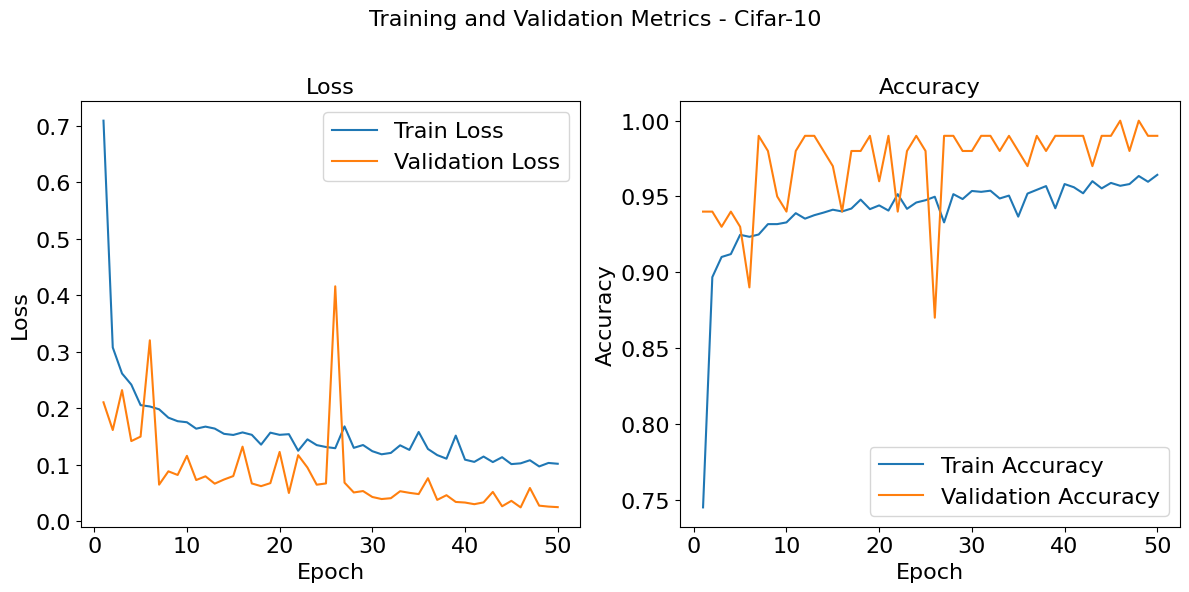

In [19]:
epochs = list(range(1, len(train_loss_list) + 1))

plt.figure(figsize=(12, 6))

# Main title for the figure
plt.suptitle('Training and Validation Metrics - Cifar-10', fontsize=16)

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_list, label='Train Loss')
plt.plot(epochs, val_loss_list, label='Validation Loss')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss', fontsize=16)
plt.xticks(fontsize=16)  # Increase font size of x-ticks
plt.yticks(fontsize=16)  # Increase font size of y-ticks
plt.legend(fontsize=16)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_list, label='Train Accuracy')
plt.plot(epochs, val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy', fontsize=16)
plt.xticks(fontsize=16)  # Increase font size of x-ticks
plt.yticks(fontsize=16)  # Increase font size of y-ticks
plt.legend(fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to leave space for main title
plt.savefig("multiclass_cifar10.pdf", bbox_inches='tight', dpi=100)
plt.show()


In [20]:
import time

start_time = time.time()
# Compute confusion matrix
def collect_predictions_and_labels(loader):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x, y in loader:
            y_hat = best_model(x)
            preds = y_hat.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Get predictions and true labels
preds, labels = collect_predictions_and_labels(test_loader)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken for prediction: {elapsed_time:.4f} seconds")

Time taken for prediction: 121.4876 seconds


In [21]:
# Get predictions and true labels
preds, labels = collect_predictions_and_labels(test_loader)
print("Balanced accuracy score: ", balanced_accuracy_score(labels, preds))
print("\nClassification Report:\n", classification_report(labels, preds))
report = classification_report(labels, preds, output_dict=True)
print("\nClassification Report:\n", report)

Balanced accuracy score:  0.9483242039544443

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       204
           1       0.85      0.96      0.90       212
           2       0.99      0.99      0.99       379
           3       0.99      0.98      0.98       204
           4       0.97      0.96      0.97       169
           5       0.95      0.80      0.87       173

    accuracy                           0.96      1341
   macro avg       0.96      0.95      0.95      1341
weighted avg       0.96      0.96      0.96      1341


Classification Report:
 {'0': {'precision': 0.9855072463768116, 'recall': 1.0, 'f1-score': 0.9927007299270074, 'support': 204}, '1': {'precision': 0.8458333333333333, 'recall': 0.9575471698113207, 'f1-score': 0.8982300884955751, 'support': 212}, '2': {'precision': 0.9947229551451188, 'recall': 0.9947229551451188, 'f1-score': 0.9947229551451188, 'support': 379}, '3': {'precision': 0.9

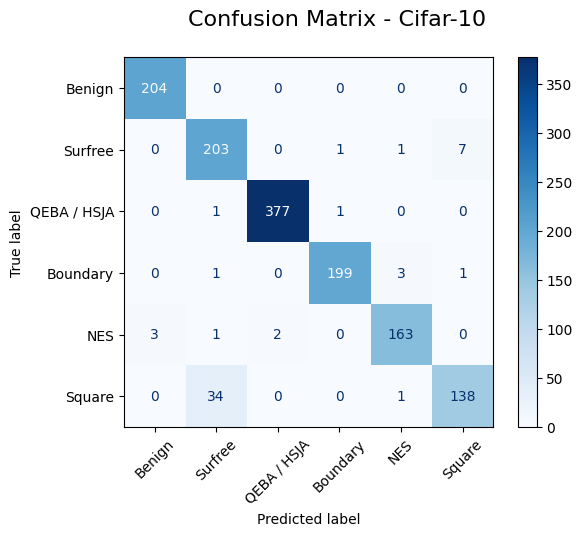

In [22]:
conf_matrix = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Benign','Surfree', 'QEBA / HSJA', 'Boundary', 'NES', 'Square'])
disp.plot(cmap='Blues', xticks_rotation=45)
plt.suptitle('Confusion Matrix - Cifar-10', fontsize=16)
plt.savefig("confusion_matrix_multiclass_cifar10.pdf", bbox_inches='tight', dpi=100)
plt.show()